In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.transforms import Bbox


In [8]:
df = pd.read_csv("combined_results.csv")

metric = "LogLoss"
df = df[df["metric"] == metric]
#df = df[df['suite_id'] == 336]

splits = [s for s in df["split_method"].unique() if s.lower() != "random_split"]
 
method_order = [
    'ConstantPredictor', 'LogisticRegressor' , 'RandomForestClassifier', 'RandomForestRegressor', 'LGBMClassifier', 'LGBMRegressor',
    'Engression', 'MLP', 'ResNet', 'FTTransformer'
]
rename_map = {
    'RandomForestClassifier': 'Random Forest',
    'RandomForestRegressor': 'Random Forest',
    'LGBMClassifier': 'Boosted Trees',
    'LGBMRegressor': 'Boosted Trees',
    'FTTransformer': 'FT-Transformer',
    'LogisticRegressor': 'Logistic Regression',
}

# 3) Extract unique suites, metrics, and extrapolation methods
suites  = df['suite_id'].unique()
metrics = df['metric'].unique()
methods = df['split_method'].unique()

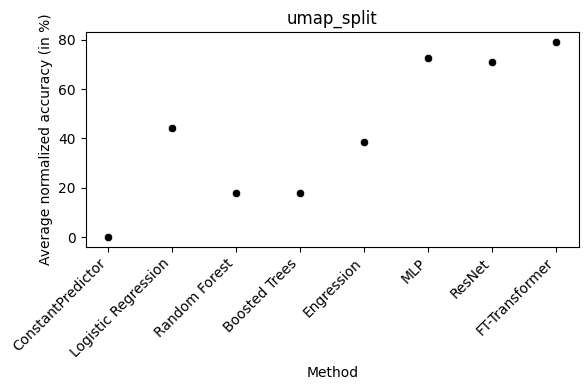

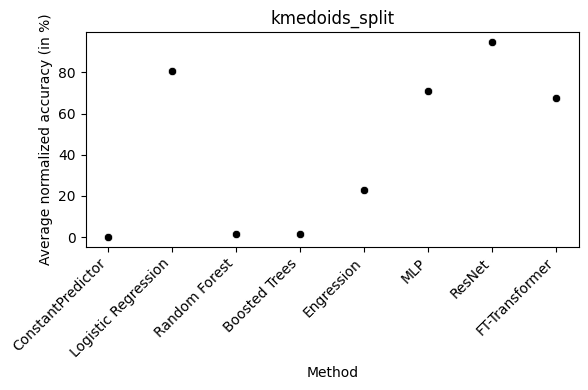

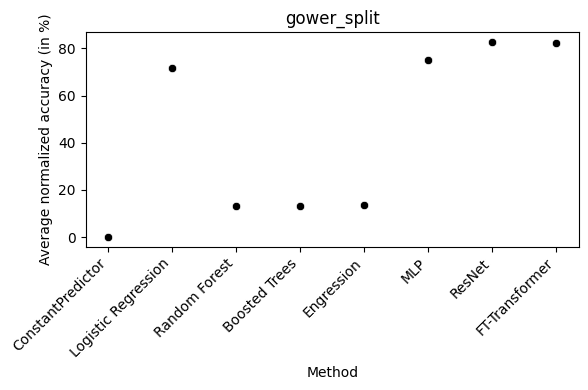

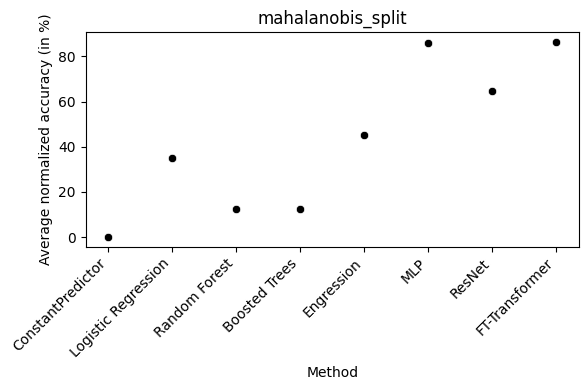

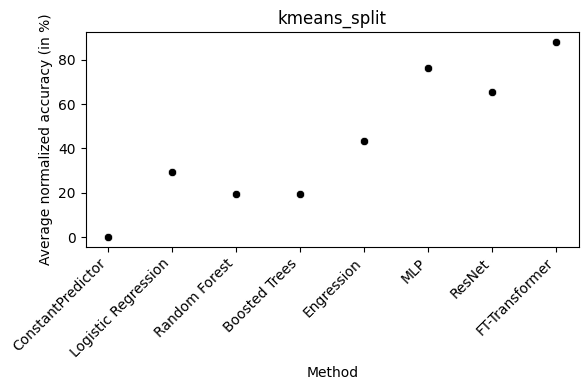

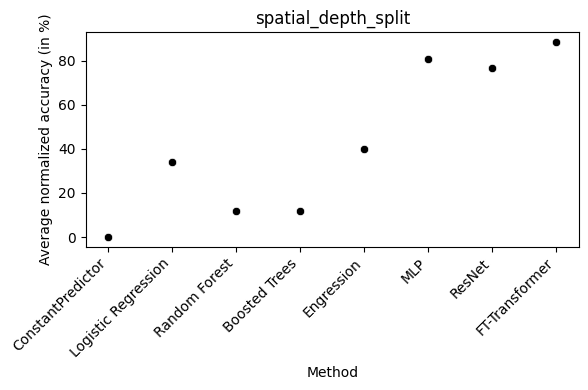

In [9]:
outdir = os.path.join('PICTURES', metric.lower())
os.makedirs(outdir, exist_ok=True)

for split in splits:
    sub = df[df["split_method"] == split]
    if sub.empty:
        continue

    table = sub.pivot(
        index="model",
        columns="task_id",
        values="value"
    )

    baseline = table.min(axis=0)
    def third_largest(series: pd.Series) -> float:
        return series.dropna().nlargest(3).min()


    mid_err  = table.apply(third_largest, axis=0)

    norm_acc = (mid_err - table).div(mid_err - baseline, axis=1).clip(0, 1)

    summary = pd.DataFrame({
        "Mean": norm_acc.mean(axis=1),
        "Median": norm_acc.median(axis=1),
        "Std": norm_acc.std(axis=1)
    }).reset_index().rename(columns={"model": "Method"})

    summary["Method"] = pd.Categorical(
        summary["Method"],
        categories=method_order,
        ordered=True
    )
    summary = summary.sort_values("Method")
    summary["Method"] = summary["Method"].astype(str).map(rename_map).fillna(summary["Method"].astype(str))

    summary["Mean"] = 100 * summary["Mean"]

    plt.figure(figsize=(6, 4))
    sns.scatterplot(data=summary, x="Method", y="Mean", color='black')
    plt.xlabel("Method")
    plt.ylabel("Average normalized accuracy (in %)")
    plt.title(f"{split}")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    fname = f"{split}_relative_diff_{metric}.png"
    plt.savefig(os.path.join(outdir, fname), bbox_inches='tight')
    plt.show()




In [5]:
df = df[df["metric"] == "LogLoss"]

df = df[df["split_method"] != "random_split"]


=== RAW normalized_accuracy sample ===
      split_method  task_id              model      value  baseline       mid  \
1     random_split   361110  LogisticRegressor   0.511903  0.401918  0.693147   
3     random_split   361110  ConstantPredictor  18.238089  0.401918  0.693147   
5       umap_split   361110  LogisticRegressor   0.597111  0.543525  0.693147   
7       umap_split   361110  ConstantPredictor  18.958962  0.543525  0.693147   
9   kmedoids_split   361110  LogisticRegressor   0.512814  0.507872  0.693147   
11  kmedoids_split   361110  ConstantPredictor  20.997524  0.507872  0.693147   
13     gower_split   361110  LogisticRegressor   0.452231  0.427206  0.693147   
15     gower_split   361110  ConstantPredictor  20.941363  0.427206  0.693147   
17    random_split   361110         Engression   0.617910  0.401918  0.693147   
18    random_split   361110                MLP   0.420350  0.401918  0.693147   
20    random_split   361110             ResNet   0.427179  0.401918  

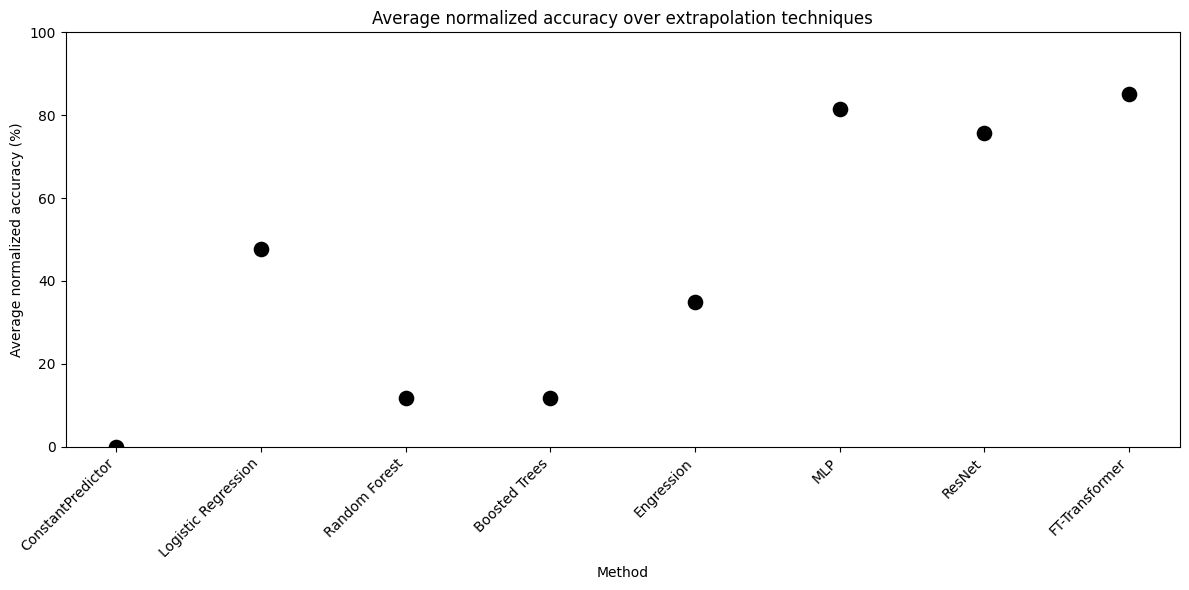

In [ ]:
# helper to get the 3rd‐largest (or worst if <3)
def third_largest(s: pd.Series) -> float:
    vals = s.dropna().nlargest(3)
    return vals.min() if not vals.empty else np.nan

# 1) baseline (best = min error) per split & task
df["baseline"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform("min")
)

# 2) mid (3rd‐largest error) per split & task
df["mid"] = (
    df
    .groupby(["split_method", "task_id"])["value"]
    .transform(third_largest)
)

# 3) normalized accuracy: (mid – err)/(mid – best), clipped into [0,1]
df["normalized_accuracy"] = (
    (df["mid"] - df["value"])
    / (df["mid"] - df["baseline"])
).clip(0, 1)

print("\n=== RAW normalized_accuracy sample ===")
print(df[['split_method','task_id','model','value','baseline','mid','normalized_accuracy']].head(20))

print("\n=== per-model normalized_accuracy summary ===")
print(
    df
    .groupby('model')["normalized_accuracy"]
    .agg(count='count', mean='mean', min='min', max='max')
    .sort_values('mean', ascending=False)
)

print("\n=== model appearance counts ===")
print(
    df
    .groupby('model')["normalized_accuracy"]
    .count()
    .sort_values(ascending=False)
)

overall = (
    df
    .groupby('model')["normalized_accuracy"]
    .mean()
    .reset_index(name='Mean')
)
overall['Mean'] *= 100   # to percent

method_order = [
    'ConstantPredictor','LogisticRegressor',
    'RandomForestClassifier','RandomForestRegressor',
    'LGBMClassifier','LGBMRegressor','Engression',
    'MLP','ResNet','FTTransformer','DGBT','DRF'
]
overall = (
    overall
    .set_index('model')
    .reindex(method_order)
    .reset_index()
)
rename_map = {
    'RandomForestClassifier':'Random Forest',
    'RandomForestRegressor':'Random Forest',
    'LGBMClassifier':       'Boosted Trees',
    'LGBMRegressor':        'Boosted Trees',
    'FTTransformer':        'FT-Transformer',
    'LogisticRegressor':   'Logistic Regression',
}
overall['Method'] = overall['model'].map(rename_map).fillna(overall['model'])

plt.figure(figsize=(12,6))
sns.scatterplot(
    data=overall,
    x='Method',
    y='Mean',
    color='black',
    s=150
)
plt.xticks(rotation=45, ha='right')
plt.ylabel('Average normalized accuracy (%)')
plt.xlabel('Method')
plt.title('Average normalized accuracy over extrapolation techniques')
plt.ylim(0, 100)
plt.tight_layout()

os.makedirs('PICTURES', exist_ok=True)
fname = f"PICTURES/avg_normalized_acc_over_extrapolation_{metric}.png"
plt.savefig(
    fname,
    bbox_inches='tight'
)
plt.show()
